In [146]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import statsmodels.api as sm
import time

from scipy import stats
from scipy.stats import norm
# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)

def summaryStats(X,feature_list):
    q1 = X[feature_list].quantile(0.25)
    q3 = X[feature_list].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             null_values = X[feature_list].isnull().sum(),
                             lower_bound = fence_low,
                             upper_bound = fence_high,
                             outliers_from_IQR = ((X[feature_list] < fence_low) | (X[feature_list] > fence_high)).sum(),
                             outliers_from_Zscore = (np.abs(stats.zscore(X[feature_list])) > 3).sum()
                            ))
    return temp

def target_by_cats(X):
    '''
    This function assumes the input dataframe (X) has a numerically defined target
    variable in the first column and that all remaining features are categorical
    '''
    global_mean = X.iloc[:,0].mean()
    target = X.columns[0]
    for col in X.columns[1:]:
        df_group = X.groupby(by=col)[target].agg(['mean','count']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        df_group['%diff'] = (df_group['diff']/df_group['mean'])*100
        display(df_group)
        
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

def decision_tree_grid_search():
    max_depth = []
    min_impurity_decrease = []
    min_samples_split = []    
    df_output = pd.DataFrame()
    
    df_output['Accuracy'] = gridSearch.cv_results_.get('mean_test_accuracy')
    df_output['Recall'] = gridSearch.cv_results_.get('mean_test_recall')
    df_output['Precision'] = gridSearch.cv_results_.get('mean_test_precision')
    
    for result in gridSearch.cv_results_.get('params'):
        max_depth.append(result.get('max_depth'))
        min_impurity_decrease.append(result.get('min_impurity_decrease'))
        min_samples_split.append(result.get('min_samples_split'))

    df_output['Max Depth'] = max_depth
    df_output['Minimum Impurity Decrease'] = min_impurity_decrease
    df_output['Minimum Samples Split'] = min_samples_split
    df_output['Model'] = 'Decision Tree'
    
    return df_output

def plot_feature_importances(data,model):
    n_features = data.shape[1]
    fig = plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics


# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)
def class_perf_measures(model,X_test,y_test, initial_th, final_th, interval):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    TP_per = []
    TN_per = []
    FP_per = []
    FN_per = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    
    # Create list of probability threshold values to loop over
    threshold = np.arange(initial_th,final_th + interval,interval).tolist()

    # Start loop
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,1]
        TN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,0]
        FP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,1]
        FN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,0]
        TP.append(TP_value)
        TN.append(TN_value)
        FP.append(FP_value)
        FN.append(FN_value)
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        TP_per.append(TP_value/(len(y_test))*100)
        TN_per.append(TN_value/(len(y_test))*100)
        FP_per.append(FP_value/(len(y_test))*100)
        FN_per.append(FN_value/(len(y_test))*100)

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "TP%": TP_per,
                           "TN%": TN_per,
                           "FP%": FP_per,
                           "FN%": FN_per,
                           "Precision":precision,
                           "Recall":recall,
                           "Accuracy": Accuracy,
                           "F1": F1
                          })

    # Let's look at our dataframe
    return result


# Exploratory Data Analysis

In [147]:
df = pd.read_csv("hotel_bookings.csv")
df.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.00,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.00,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.00,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.00,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.00,NaN,0,Transient,151.20,0,2,Check-Out,2017-09-07


In [148]:
df.shape

(119390, 32)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [150]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [151]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.00,0.37,0.48,0.00,0.00,0.00,1.00,1.00
lead_time,119390.00,104.01,106.86,0.00,18.00,69.00,160.00,737.00
arrival_date_year,119390.00,2016.16,0.71,2015.00,2016.00,2016.00,2017.00,2017.00
arrival_date_week_number,119390.00,27.17,13.61,1.00,16.00,28.00,38.00,53.00
arrival_date_day_of_month,119390.00,15.80,8.78,1.00,8.00,16.00,23.00,31.00
stays_in_weekend_nights,119390.00,0.93,1.00,0.00,0.00,1.00,2.00,19.00
stays_in_week_nights,119390.00,2.50,1.91,0.00,1.00,2.00,3.00,50.00
adults,119390.00,1.86,0.58,0.00,2.00,2.00,2.00,55.00
children,119386.00,0.10,0.40,0.00,0.00,0.00,0.00,10.00
babies,119390.00,0.01,0.10,0.00,0.00,0.00,0.00,10.00


# Treating with Duplicates, Nulls and Outliers

In [152]:
print("Records before dropping dups", len(df))
df.drop_duplicates(inplace=True,ignore_index=True)
print("Records after dropping dups", len(df))

Records before dropping dups 119390
Records after dropping dups 87396


In [153]:
df_numerical = df.select_dtypes(include=['int64','float64'])
#lets drop is_repeted guest as it is binary column
df_numerical.drop(columns=['is_repeated_guest'], inplace=True)

In [154]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.00,0,0,0,3,NaN,NaN,0,0.00,0,0
1,0,737,2015,27,1,0,0,2,0.00,0,0,0,4,NaN,NaN,0,0.00,0,0
2,0,7,2015,27,1,0,1,1,0.00,0,0,0,0,NaN,NaN,0,75.00,0,0
3,0,13,2015,27,1,0,1,1,0.00,0,0,0,0,304.00,NaN,0,75.00,0,0
4,0,14,2015,27,1,0,2,2,0.00,0,0,0,0,240.00,NaN,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,0,23,2017,35,30,2,5,2,0.00,0,0,0,0,394.00,NaN,0,96.14,0,0
87392,0,102,2017,35,31,2,5,3,0.00,0,0,0,0,9.00,NaN,0,225.43,0,2
87393,0,34,2017,35,31,2,5,2,0.00,0,0,0,0,9.00,NaN,0,157.71,0,4
87394,0,109,2017,35,31,2,5,2,0.00,0,0,0,0,89.00,NaN,0,104.40,0,0


In [155]:
summaryStats(df_numerical,df_numerical.columns)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
is_canceled,0.27,0.00,0.45,0.00,1.00,0,-1.50,2.50,0,0
lead_time,79.89,49.00,86.05,0.00,737.00,0,-160.00,296.00,2396,1049
arrival_date_year,2016.21,2016.00,0.69,2015.00,2017.00,0,2014.50,2018.50,0,0
arrival_date_week_number,26.84,27.00,13.67,1.00,53.00,0,-15.50,68.50,0,0
arrival_date_day_of_month,15.82,16.00,8.84,1.00,31.00,0,-14.50,45.50,0,0
stays_in_weekend_nights,1.01,1.00,1.03,0.00,19.00,0,-3.00,5.00,220,290
stays_in_week_nights,2.63,2.00,2.05,0.00,50.00,0,-3.50,8.50,1531,1531
adults,1.88,2.00,0.63,0.00,55.00,0,2.00,2.00,22899,76
children,0.14,0.00,0.46,0.00,10.00,4,0.00,0.00,8364,0
babies,0.01,0.00,0.11,0.00,10.00,0,0.00,0.00,914,914


**Observations**

- nulls present in agent and company 
- It might be because the booking was done individually 
- Check how many records have both agent and company

In [156]:
df_numerical[~np.isnan(df_numerical['agent']) & ~np.isnan(df_numerical['company'])]

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2208,0,6,2015,42,11,2,0,2,0.00,0,0,0,1,240.00,113.00,0,82.00,1,1
2442,0,24,2015,44,26,7,15,1,0.00,0,0,0,2,185.00,281.00,0,52.20,0,0
2580,0,24,2015,45,3,0,3,2,0.00,0,0,0,1,334.00,281.00,0,48.00,0,0
2590,0,24,2015,45,3,2,10,1,0.00,0,0,0,2,328.00,281.00,0,40.00,0,0
2591,0,24,2015,45,3,3,10,2,0.00,0,0,0,2,326.00,281.00,0,48.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81646,0,13,2017,21,24,0,1,2,0.00,0,0,0,0,9.00,478.00,0,150.00,0,1
82087,0,13,2017,22,29,1,3,1,0.00,0,0,0,1,290.00,148.00,0,95.00,0,0
82120,0,13,2017,22,29,1,3,2,0.00,0,0,0,1,290.00,148.00,0,110.00,0,0
82579,0,210,2017,23,9,0,1,2,0.00,0,0,0,0,14.00,229.00,0,135.00,0,0


**Observations** 

- Only 189 records have both agent and company. WHich means for 188 records, company is making booking through travel agents.
- for remaining records booking is done either by agent or company or individual person 
- we can create 4 column: is_booked_individually, is_booked_by_company, is_booked_by_agent, is_booked_by_comoany_through_agent
- replace the nulls in agent by 0
- drop the company column as it comtains 81890 nulls out of87k datapoints
- there are 4 records with Nan for children, we can replace it by 0 as it is the meadin number of children

In [157]:
#adding the binary columns in main df only as this df is for numerical variables
df['booked_by'] = np.where((np.isnan(df['agent'])) & (np.isnan(df['company'])),'Individually',(np.where((~(np.isnan(df['agent']))) & (np.isnan(df['company'])),'Agent',(np.where((np.isnan(df['agent'])) & (~(np.isnan(df['company']))),'Company','Company through Agent')))))

df_numerical.drop(columns=['company'], inplace=True)
df_numerical['agent'].fillna(0.00, inplace=True)
df_numerical['children'].fillna(0.00, inplace=True)

df.drop(columns=['company'], inplace=True)
df['agent'].fillna(0.00, inplace=True)
df['children'].fillna(0.00, inplace=True)

In [158]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.00,0,0,0,3,0.00,0,0.00,0,0
1,0,737,2015,27,1,0,0,2,0.00,0,0,0,4,0.00,0,0.00,0,0
2,0,7,2015,27,1,0,1,1,0.00,0,0,0,0,0.00,0,75.00,0,0
3,0,13,2015,27,1,0,1,1,0.00,0,0,0,0,304.00,0,75.00,0,0
4,0,14,2015,27,1,0,2,2,0.00,0,0,0,0,240.00,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,0,23,2017,35,30,2,5,2,0.00,0,0,0,0,394.00,0,96.14,0,0
87392,0,102,2017,35,31,2,5,3,0.00,0,0,0,0,9.00,0,225.43,0,2
87393,0,34,2017,35,31,2,5,2,0.00,0,0,0,0,9.00,0,157.71,0,4
87394,0,109,2017,35,31,2,5,2,0.00,0,0,0,0,89.00,0,104.40,0,0


In [159]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,booked_by
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.00,0,Transient,0.00,0,0,Check-Out,2015-07-01,Individually
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.00,0,Transient,0.00,0,0,Check-Out,2015-07-01,Individually
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.00,0,Transient,75.00,0,0,Check-Out,2015-07-02,Individually
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,0,Transient,75.00,0,0,Check-Out,2015-07-02,Agent
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,0,Transient,98.00,0,1,Check-Out,2015-07-03,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,City Hotel,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,0,Transient,96.14,0,0,Check-Out,2017-09-06,Agent
87392,City Hotel,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.00,0,Transient,225.43,0,2,Check-Out,2017-09-07,Agent
87393,City Hotel,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.00,0,Transient,157.71,0,4,Check-Out,2017-09-07,Agent
87394,City Hotel,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.00,0,Transient,104.40,0,0,Check-Out,2017-09-07,Agent


In [160]:
summaryStats(df_numerical,df_numerical.columns)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
is_canceled,0.27,0.00,0.45,0.00,1.00,0,-1.50,2.50,0,0
lead_time,79.89,49.00,86.05,0.00,737.00,0,-160.00,296.00,2396,1049
arrival_date_year,2016.21,2016.00,0.69,2015.00,2017.00,0,2014.50,2018.50,0,0
arrival_date_week_number,26.84,27.00,13.67,1.00,53.00,0,-15.50,68.50,0,0
arrival_date_day_of_month,15.82,16.00,8.84,1.00,31.00,0,-14.50,45.50,0,0
stays_in_weekend_nights,1.01,1.00,1.03,0.00,19.00,0,-3.00,5.00,220,290
stays_in_week_nights,2.63,2.00,2.05,0.00,50.00,0,-3.50,8.50,1531,1531
adults,1.88,2.00,0.63,0.00,55.00,0,2.00,2.00,22899,76
children,0.14,0.00,0.46,0.00,10.00,0,0.00,0.00,8364,3669
babies,0.01,0.00,0.11,0.00,10.00,0,0.00,0.00,914,914


# **Observation**

- Now we have delt with nulls, lets see the outliers
- From summery stats, we can see many columns have potential outliers 
- we will consider z score to call a data point outlier. It is an outlier if it lies beyond 3 sigma

In [161]:
df_numerical.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [162]:
graph_columns= ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']

<Figure size 640x480 with 0 Axes>

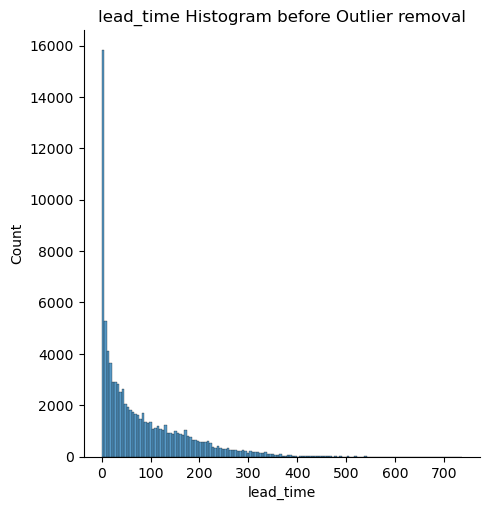

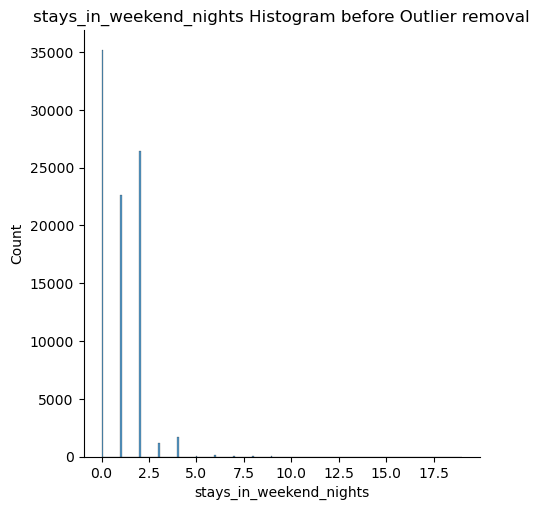

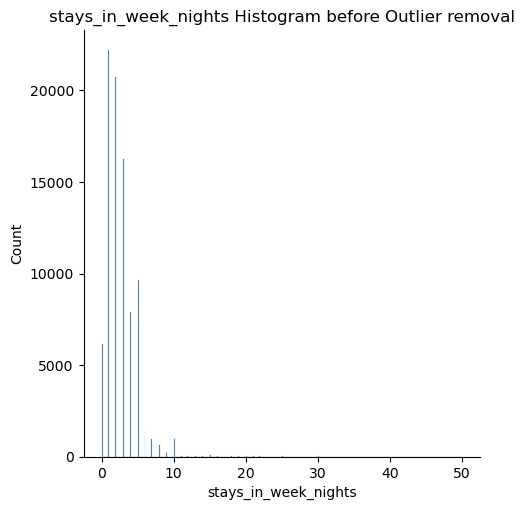

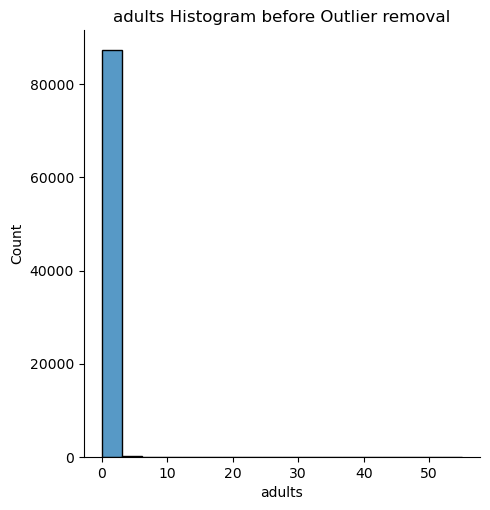

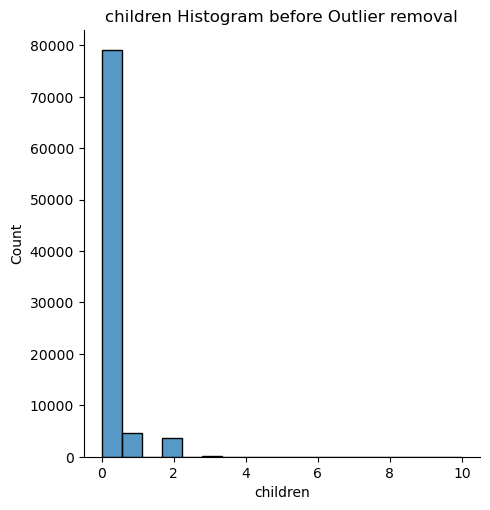

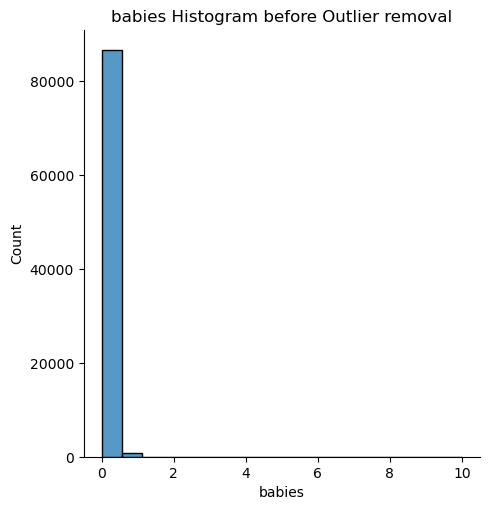

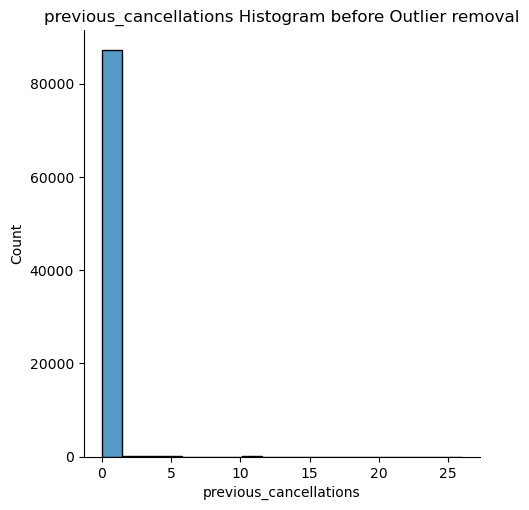

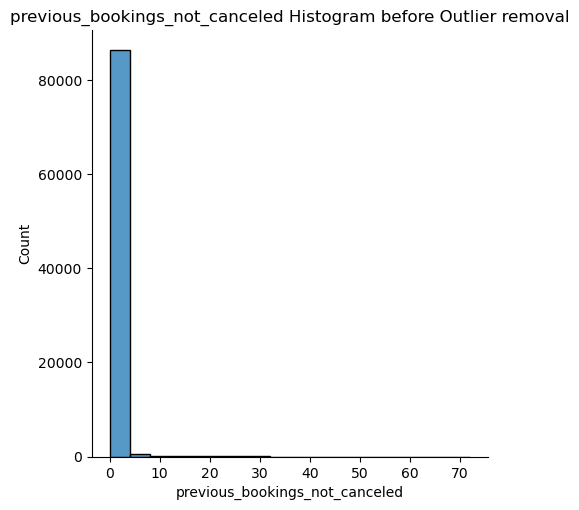

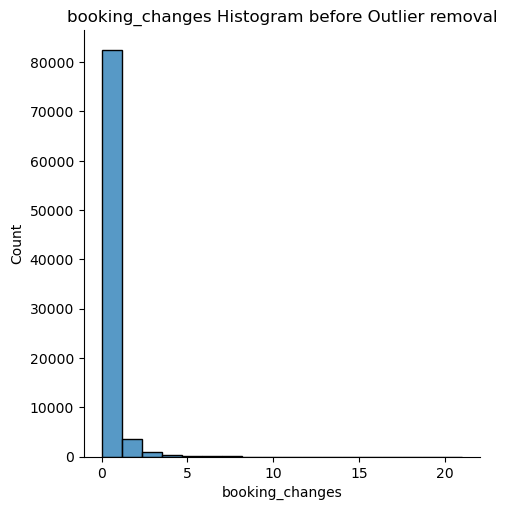

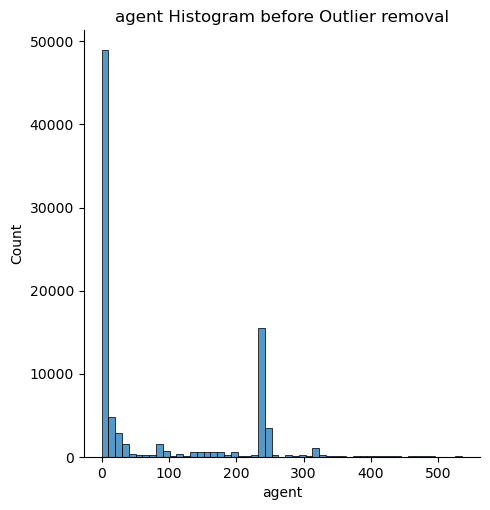

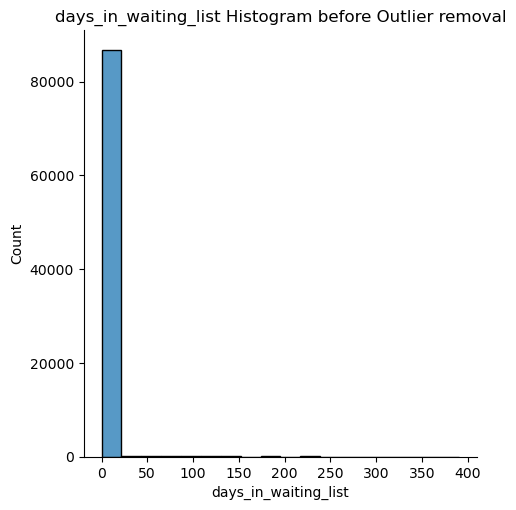

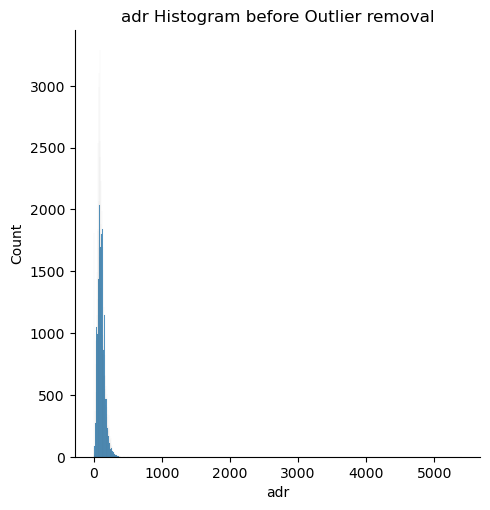

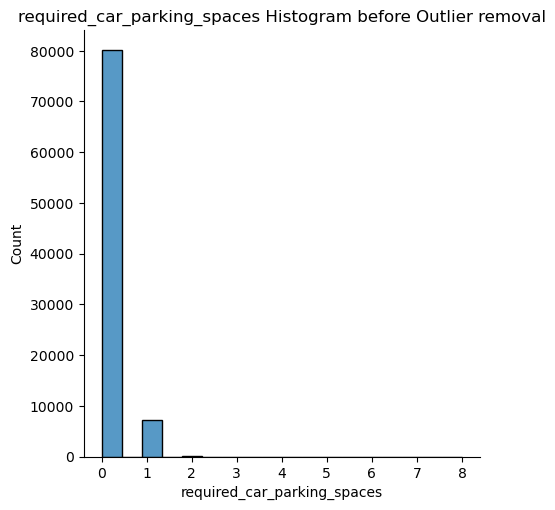

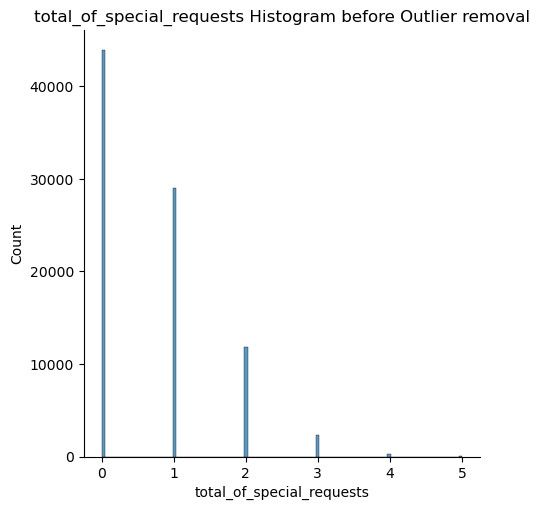

In [163]:
for i, col in enumerate(graph_columns):
    plt.figure(i)
    sns.displot(df[col])
    plt.title(col + ' Histogram before Outlier removal')  

# **Observation**
- Looking at the histogram of lead time we can see the normlization is required for lead time,  will use log transform for the normalization
- as we cant take log of 0, lets convert 0 to 1 for lead time
- We will remove other outliers using z score. If the absolute z score is more than 3 then we consider the point as outlier and remove it

In [164]:
df_numerical['lead_time'] = np.where(df_numerical['lead_time'] == 0, 1, df_numerical['lead_time'])
df_numerical['lead_time'] = np.log(df_numerical['lead_time'])

df['lead_time'] = np.where(df['lead_time'] == 0, 1, df['lead_time'])
df['lead_time'] = np.log(df['lead_time'])

In [165]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,5.83,2015,27,1,0,0,2,0.00,0,0,0,3,0.00,0,0.00,0,0
1,0,6.60,2015,27,1,0,0,2,0.00,0,0,0,4,0.00,0,0.00,0,0
2,0,1.95,2015,27,1,0,1,1,0.00,0,0,0,0,0.00,0,75.00,0,0
3,0,2.56,2015,27,1,0,1,1,0.00,0,0,0,0,304.00,0,75.00,0,0
4,0,2.64,2015,27,1,0,2,2,0.00,0,0,0,0,240.00,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,0,3.14,2017,35,30,2,5,2,0.00,0,0,0,0,394.00,0,96.14,0,0
87392,0,4.62,2017,35,31,2,5,3,0.00,0,0,0,0,9.00,0,225.43,0,2
87393,0,3.53,2017,35,31,2,5,2,0.00,0,0,0,0,9.00,0,157.71,0,4
87394,0,4.69,2017,35,31,2,5,2,0.00,0,0,0,0,89.00,0,104.40,0,0


<AxesSubplot:xlabel='lead_time', ylabel='Count'>

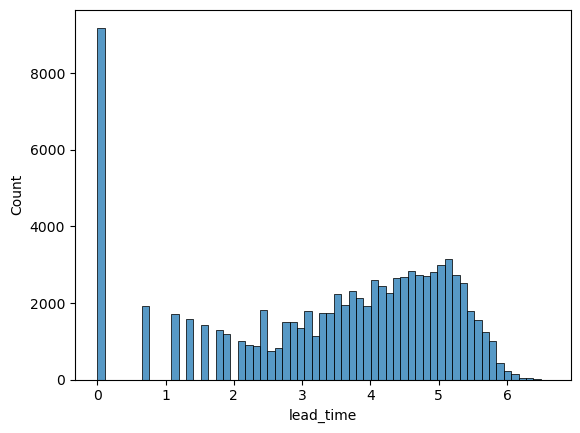

In [166]:
sns.histplot(df_numerical['lead_time'])

# Handling Ouliers and Tranformation 

In [167]:
print("Number of records before dropping outlier", len(df_numerical))
df = df[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)].reset_index(drop=True)
df_numerical = df_numerical[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)].reset_index(drop=True)
print("Number of records after dropping outlier", len(df_numerical))


Number of records before dropping outlier 87396
Number of records after dropping outlier 71263


# Feature Selection 

In [168]:
dfcorr_matrix = df.corr()
dfcorr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.00
lead_time                         0.24
previous_cancellations            0.16
adr                               0.14
adults                            0.10
arrival_date_year                 0.09
stays_in_week_nights              0.08
stays_in_weekend_nights           0.05
children                          0.03
agent                             0.02
days_in_waiting_list              0.02
arrival_date_day_of_month         0.01
arrival_date_week_number          0.01
previous_bookings_not_canceled   -0.08
is_repeated_guest                -0.08
booking_changes                  -0.10
total_of_special_requests        -0.11
babies                             NaN
required_car_parking_spaces        NaN
Name: is_canceled, dtype: float64

In [169]:
# Categorical Variables
df_categorical = df.select_dtypes(include=['object'])
df_categorical

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,booked_by
0,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,2015-07-02,Individually
1,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,2015-07-02,Agent
2,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-07-03,Agent
3,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-03,Individually
4,Resort Hotel,July,FB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-03,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71258,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-06,Agent
71259,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-06,Agent
71260,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Check-Out,2017-09-07,Agent
71261,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-07,Agent


In [170]:
# Now we will add the 2 binary column to this df and one categorical 
df_categorical.insert(loc=0, column='is_canceled',value=df['is_canceled'])
df_categorical['is_repeated_guest'] = df['is_repeated_guest']

In [171]:
#Effect of categoories in each column on target variable
target_by_cats(df_categorical)

,mean,count,diff,%diff
hotel,,,,
City Hotel,0.31,47017,0.01,3.23
Resort Hotel,0.27,24246,-0.03,-11.11


,mean,count,diff,%diff
arrival_date_month,,,,
April,0.33,6473,0.03,9.09
August,0.35,8814,0.05,14.29
December,0.30,4076,0.00,0.00
February,0.25,5082,-0.05,-20.00
January,0.24,3746,-0.06,-25.00
July,0.35,7969,0.05,14.29
June,0.33,6303,0.03,9.09
March,0.26,6379,-0.04,-15.38
May,0.31,6959,0.01,3.23


,mean,count,diff,%diff
meal,,,,
BB,0.29,55182,-0.01,-3.45
FB,0.33,238,0.03,9.09
HB,0.30,6599,0.00,0.00
SC,0.36,8961,0.06,16.67
Undefined,0.22,283,-0.08,-36.36


,mean,count,diff,%diff
country,,,,
ABW,0.00,2,-0.30,-inf
AGO,0.46,197,0.16,34.78
ALB,0.20,10,-0.10,-50.00
AND,1.00,4,0.70,70.00
ARE,0.86,35,0.56,65.12
...,...,...,...,...
VGB,1.00,1,0.70,70.00
VNM,0.25,8,-0.05,-20.00
ZAF,0.35,65,0.05,14.29


,mean,count,diff,%diff
market_segment,,,,
Aviation,0.20,196,-0.10,-50.00
Complementary,0.16,477,-0.14,-87.50
Corporate,0.14,3017,-0.16,-114.29
Direct,0.17,8496,-0.13,-76.47
Groups,0.29,3991,-0.01,-3.45
Offline TA/TO,0.15,11775,-0.15,-100.00
Online TA,0.37,43309,0.07,18.92
Undefined,1.00,2,0.70,70.00


,mean,count,diff,%diff
distribution_channel,,,,
Corporate,0.15,3672,-0.15,-100.00
Direct,0.17,9359,-0.13,-76.47
GDS,0.19,178,-0.11,-57.89
TA/TO,0.33,58050,0.03,9.09
Undefined,1.00,4,0.70,70.00


,mean,count,diff,%diff
reserved_room_type,,,,
A,0.28,49152,-0.02,-7.14
B,0.30,647,0.00,0.00
C,0.31,226,0.01,3.23
D,0.33,15003,0.03,9.09
E,0.34,4376,0.04,11.76
F,0.24,1036,-0.06,-25.00
G,0.28,532,-0.02,-7.14
H,0.57,281,0.27,47.37
L,0.40,5,0.10,25.00


,mean,count,diff,%diff
assigned_room_type,,,,
A,0.33,40956,0.03,9.09
B,0.19,1379,-0.11,-57.89
C,0.14,1153,-0.16,-114.29
D,0.27,19138,-0.03,-11.11
E,0.28,5359,-0.02,-7.14
F,0.17,1658,-0.13,-76.47
G,0.20,798,-0.10,-50.00
H,0.47,356,0.17,36.17
I,0.02,243,-0.28,-1400.00


,mean,count,diff,%diff
deposit_type,,,,
No Deposit,0.29,70324,-0.01,-3.45
Non Refund,0.95,866,0.65,68.42
Refundable,0.29,73,-0.01,-3.45


,mean,count,diff,%diff
customer_type,,,,
Contract,0.18,2519,-0.12,-66.67
Group,0.08,421,-0.22,-275.00
Transient,0.32,58862,0.02,6.25
Transient-Party,0.17,9461,-0.13,-76.47


,mean,count,diff,%diff
reservation_status,,,,
Canceled,1.00,20243,0.70,70.00
Check-Out,0.00,50129,-0.30,-inf
No-Show,1.00,891,0.70,70.00


,mean,count,diff,%diff
reservation_status_date,,,,
2014-10-17,1.00,9,0.70,70.00
2014-11-18,1.00,1,0.70,70.00
2015-01-01,1.00,43,0.70,70.00
2015-01-02,1.00,2,0.70,70.00
2015-01-20,1.00,1,0.70,70.00
...,...,...,...,...
2017-09-06,0.00,13,-0.30,-inf
2017-09-07,0.00,12,-0.30,-inf
2017-09-08,0.00,1,-0.30,-inf


,mean,count,diff,%diff
booked_by,,,,
Agent,0.32,62214,0.02,6.25
Company,0.13,3643,-0.17,-130.77
Company through Agent,0.11,126,-0.19,-172.73
Individually,0.16,5280,-0.14,-87.50


,mean,count,diff,%diff
is_repeated_guest,,,,
0,0.30,69170,0.00,0.00
1,0.09,2093,-0.21,-233.33


**Observations**
- Hotel: cancellation % doesn't change much with the hotel type
- Month: April, May, June, July, august have more than 30% booking of cancellation 
- Meal: BB, FB, HB constitute to majority of meals and there is very less change in %cancellation in these type of meals
- 172 countries we can bucket this column according to continent or ignore the column. For now i will ignore it
- market_segemt: There is significcant difference in % with marcket segment
- distribution_channel: here also % changes with distribution channel
- reserved room type: We might want to bucket it and keep top 4 and classify remainings as 'other'. % is not chaging that much with reserved room type.
- assigned room type: Again we might want to bucket it but % is not changing much
- deposit type: even though almost all the records are for no deposit, non refundable records are being cancelled 95% of the time which is very big number
- customer type: % is changing
- booked_by: % is changing considerably
- is_repeated guest: if guest is repeated then he/she cancel the booking only for 9% of the times
- reservation_status: This variable has very high predictive power. Whenever status is check-out, then target variable is alwasy 0 and if status is not check-out then target will be always 1 	

**Conclusion**
- Categorical variables to consider: 'Marcket_segment','deposit_type','customer_type','booked_by','is_repeated_guest'

**Tasks**
- Create a column is_room_changed which specifies if assigned room is not same as reserved room 
- Reduce the unique values in country, reserved room type and assigned room type column by keeping the top few recordsand merging the remaining records in 'other' category
- Convert the text month column into month number 



In [72]:
df_categorical['is_room_changed'] = np.where((df_categorical['reserved_room_type'] == df_categorical['assigned_room_type']),0,1)
df['is_room_changed'] = np.where((df_categorical['reserved_room_type'] == df_categorical['assigned_room_type']),0,1)   

In [73]:
top_5_countries = df_categorical.groupby('country')['is_canceled'].count().sort_values(ascending=False).head(5)
top_3_reserved_room_types = df_categorical.groupby('reserved_room_type')['is_canceled'].count().sort_values(ascending=False).head(3)
top_3_assigned_room_types = df_categorical.groupby('assigned_room_type')['is_canceled'].count().sort_values(ascending=False).head(3)

In [74]:
df.loc[~(df_categorical['country'].isin(top_5_countries.index)),'country'] = 'Other'
df.loc[~(df_categorical['reserved_room_type'].isin(top_3_reserved_room_types.index)),'reserved_room_type'] = 'Other'
df.loc[~(df_categorical['assigned_room_type'].isin(top_3_assigned_room_types.index)),'assigned_room_type'] = 'Other'

df_categorical.loc[~(df_categorical['country'].isin(top_5_countries.index)),'country'] = 'Other'
df_categorical.loc[~(df_categorical['reserved_room_type'].isin(top_3_reserved_room_types.index)),'reserved_room_type'] = 'Other'
df_categorical.loc[~(df_categorical['assigned_room_type'].isin(top_3_assigned_room_types.index)),'assigned_room_type'] = 'Other'

In [75]:
categorical_columns = df_categorical.loc[:, df_categorical.columns != 'is_canceled']

# for i, col in enumerate(categorical_columns):
#     f = plt.figure(figsize=(20,8))
#     plt.figure(i)
#     sns.countplot(data=df_categorical, x = df_categorical[col], hue=df_categorical['is_canceled'])
#     plt.title(col + ' Histogram before Outlier removal') 

In [76]:
categorical_columns

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,booked_by,is_repeated_guest,is_room_changed
0,Resort Hotel,July,BB,PRT,Direct,Direct,Other,Other,No Deposit,Transient,Check-Out,2015-07-01,Individually,0,0
1,Resort Hotel,July,BB,PRT,Direct,Direct,Other,Other,No Deposit,Transient,Check-Out,2015-07-01,Individually,0,0
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,Other,No Deposit,Transient,Check-Out,2015-07-02,Individually,0,1
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,2015-07-02,Agent,0,0
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-07-03,Agent,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,City Hotel,August,BB,Other,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-06,Agent,0,0
87392,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Check-Out,2017-09-07,Agent,0,0
87393,City Hotel,August,BB,DEU,Online TA,TA/TO,D,D,No Deposit,Transient,Check-Out,2017-09-07,Agent,0,0
87394,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-07,Agent,0,0


In [77]:
month_map = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
df.arrival_date_month = df.arrival_date_month.map(month_map).astype(int)

In [78]:
df_small = df[['is_canceled','lead_time','previous_cancellations','adr','total_of_special_requests','market_segment','deposit_type','customer_type','booked_by','is_room_changed','country','agent','booking_changes','arrival_date_week_number','arrival_date_year','reservation_status']]

In [79]:
df_small

,is_canceled,lead_time,previous_cancellations,adr,total_of_special_requests,market_segment,deposit_type,customer_type,booked_by,is_room_changed,country,agent,booking_changes,arrival_date_week_number,arrival_date_year,reservation_status
0,0,5.8348,0,0.0000,0,Direct,No Deposit,Transient,Individually,0,PRT,0.0000,3,27,2015,Check-Out
1,0,6.6026,0,0.0000,0,Direct,No Deposit,Transient,Individually,0,PRT,0.0000,4,27,2015,Check-Out
2,0,1.9459,0,75.0000,0,Direct,No Deposit,Transient,Individually,1,GBR,0.0000,0,27,2015,Check-Out
3,0,2.5649,0,75.0000,0,Corporate,No Deposit,Transient,Agent,0,GBR,304.0000,0,27,2015,Check-Out
4,0,2.6391,0,98.0000,1,Online TA,No Deposit,Transient,Agent,0,GBR,240.0000,0,27,2015,Check-Out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,0,3.1355,0,96.1400,0,Offline TA/TO,No Deposit,Transient,Agent,0,Other,394.0000,0,35,2017,Check-Out
87392,0,4.6250,0,225.4300,2,Online TA,No Deposit,Transient,Agent,0,FRA,9.0000,0,35,2017,Check-Out
87393,0,3.5264,0,157.7100,4,Online TA,No Deposit,Transient,Agent,0,DEU,9.0000,0,35,2017,Check-Out
87394,0,4.6913,0,104.4000,0,Online TA,No Deposit,Transient,Agent,0,GBR,89.0000,0,35,2017,Check-Out


In [80]:
df = df_small

In [84]:
param = ['lead_time', 'previous_cancellations', 'adr',
       'total_of_special_requests', 'is_room_changed', 'agent',
       'booking_changes', 'arrival_date_week_number', 'arrival_date_year',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'booked_by_Agent', 'booked_by_Company',
       'booked_by_Company through Agent', 'booked_by_Individually',
       'country_DEU', 'country_ESP', 'country_FRA', 'country_GBR',
       'country_Other', 'country_PRT', 'reservation_status_Canceled',
       'reservation_status_Check-Out', 'reservation_status_No-Show']

# One hot encoding

In [81]:
#Convering categorical to binary
df = pd.get_dummies(df, prefix_sep='_', drop_first=False)

#train test split
train_var = df.drop(['is_canceled'], axis=1)
test_var = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(train_var, test_var, test_size=0.20, random_state=1)

# Normalization

In [85]:
#Data scaling
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [87]:
X_train

,lead_time,previous_cancellations,adr,total_of_special_requests,is_room_changed,agent,booking_changes,arrival_date_week_number,arrival_date_year,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,booked_by_Agent,booked_by_Company,booked_by_Company through Agent,booked_by_Individually,country_DEU,country_ESP,country_FRA,country_GBR,country_Other,country_PRT,reservation_status_Canceled,reservation_status_Check-Out,reservation_status_No-Show
24662,2.5649,0,38.0000,1,0,368.0000,2,45,2016,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0
29869,2.7081,0,95.0000,0,0,250.0000,2,17,2017,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0
6652,5.4972,0,120.0000,1,0,240.0000,0,43,2016,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0
17343,0.0000,0,55.0000,1,1,0.0000,0,11,2016,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0
65679,4.5951,0,141.7500,2,0,9.0000,0,30,2016,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21440,4.6444,0,252.6000,0,1,5.0000,6,30,2016,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0
73349,5.7462,0,91.8000,1,0,9.0000,0,49,2016,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0
50057,4.5951,0,250.0000,0,0,9.0000,0,23,2017,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0
5192,4.9273,0,187.0000,1,0,240.0000,0,29,2016,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0


In [121]:
df_results = pd.DataFrame()

# Logistic Regression 

In [172]:
start_time = time.time()
logreg = LogisticRegression(max_iter=500).fit(X_train_std, y_train)
scores = cross_val_score(logreg, X_train_std, y_train, cv=5)
logreg_pred = logreg.predict(X_test_std)
features_used = len(logreg.coef_[0][(logreg.coef_[0] > 0.01) | (logreg.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)

#Calculating avg Cross Validation score :

print("Average cross validation score: {:.5f}".format(scores.mean()))
print("Test accuracy: {:.5f}".format(logreg.score(X_test_std, y_test)))


logreg_dict = {"Model": "Logistic Regression",
              "Accuracy": round(logreg.score(X_test_std, y_test),3),
              "Recall": round(recall_score(y_test, logreg_pred),3),
              "Precision": round(precision_score(y_test, logreg_pred),3),
              "False Negative": confusion_matrix(y_test, logreg_pred)[1][0],
              "False Positive": confusion_matrix(y_test, logreg_pred)[0][1],
              "Features Used": features_used,
              "Time in seconds": time.time() - start_time}
df_results = df_results.append(logreg_dict,ignore_index=True)
print("--- %s seconds ---" % (time.time() - start_time))

Average cross validation score: 1.00000
Test accuracy: 1.00000
--- 0.5365657806396484 seconds ---


C:\Users\anagbhid\AppData\Local\Temp\ipykernel_2148\2816364984.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(logreg_dict,ignore_index=True)


# Probability Threshold determination

In [174]:
class_perf_measures(logreg, X_test_std, y_test,0,1,0.1)

C:\Users\anagbhid\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,4692,0,12788,0,26.84,0.00,73.16,0.00,0.27,1.00,0.27,0.42
1,0.10,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
2,0.20,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
3,0.30,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
4,0.40,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
5,0.50,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
6,0.60,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
7,0.70,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
8,0.80,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00
9,0.90,4692,12788,0,0,26.84,73.16,0.00,0.00,1.00,1.00,1.00,1.00


**For selecting probability classification threshold we need to understand what TP, TN, FP, FN explains in business terms**

>-TP: Booking gets cancelled and it is predicted as cancelled

>-TN: Booking is not cancelled and is predicted that booking is not canclled  

>-FP: Booking is not cancelled but it is predicted that is cancelled

>-FN: Booking is cancelled and it is predicted that it is not cancelled


We can say that FN is a very costly parameter here because cancelled booking is getting predicted as not cancelled. Which means Even if the Hotel has vacancy it would be showing as Fully booked. This is bad as if there is any newbooking. The hotel might not consider this as it would be shown as fully booked.

Considering above scenario, we should try to **decrease the False Negatives**, as we decrease FN, we would be able to predict correctly if there are more vacancies or not.

If we are predicting correct vacancy we can increase the revenue, if not increase , we can atleast save the revenue loss for those rooms which are vacant and are predicted as not cancelled.

Since our focus id to decrease the False Negatives, we should choose the threshold in such a manner that we are dachieveing max **Recall with maximum Accuracy**.

By looking into the above table, we can see our model is working perfectly with threshold of 0.50, with an **Accuracy** of **1** and **Recall** of **1**. I think we should consider threshold in such a manner that both Accuracy and Recall are **Maximum**.

# Decision Tree using Grid SearchCV

In [179]:
start_time = time.time()
param_grid = {
    'max_depth': [5,10],
    'min_samples_split': [5,10,20],
    'min_impurity_decrease': [0, 0.001]
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1,  #used to marshall all available CPUs
                          scoring=['accuracy','recall','precision'],
                          refit='accuracy'
                         )
gridSearch.fit(X_train,y_train)

best_model_results = pd.DataFrame(gridSearch.cv_results_).loc[gridSearch.best_index_]
total_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.072518348693848 seconds ---


In [182]:
# best_model_results
#best hypertuned parameters 
print("Max Depth : ", gridSearch.best_estimator_.max_depth)
print("Minimum Sample : ", gridSearch.best_estimator_.min_samples_split)
print("Impurity Decrease : ", gridSearch.best_estimator_.min_impurity_decrease)

Max Depth :  5
Minimum Sample :  5
Impurity Decrease :  0


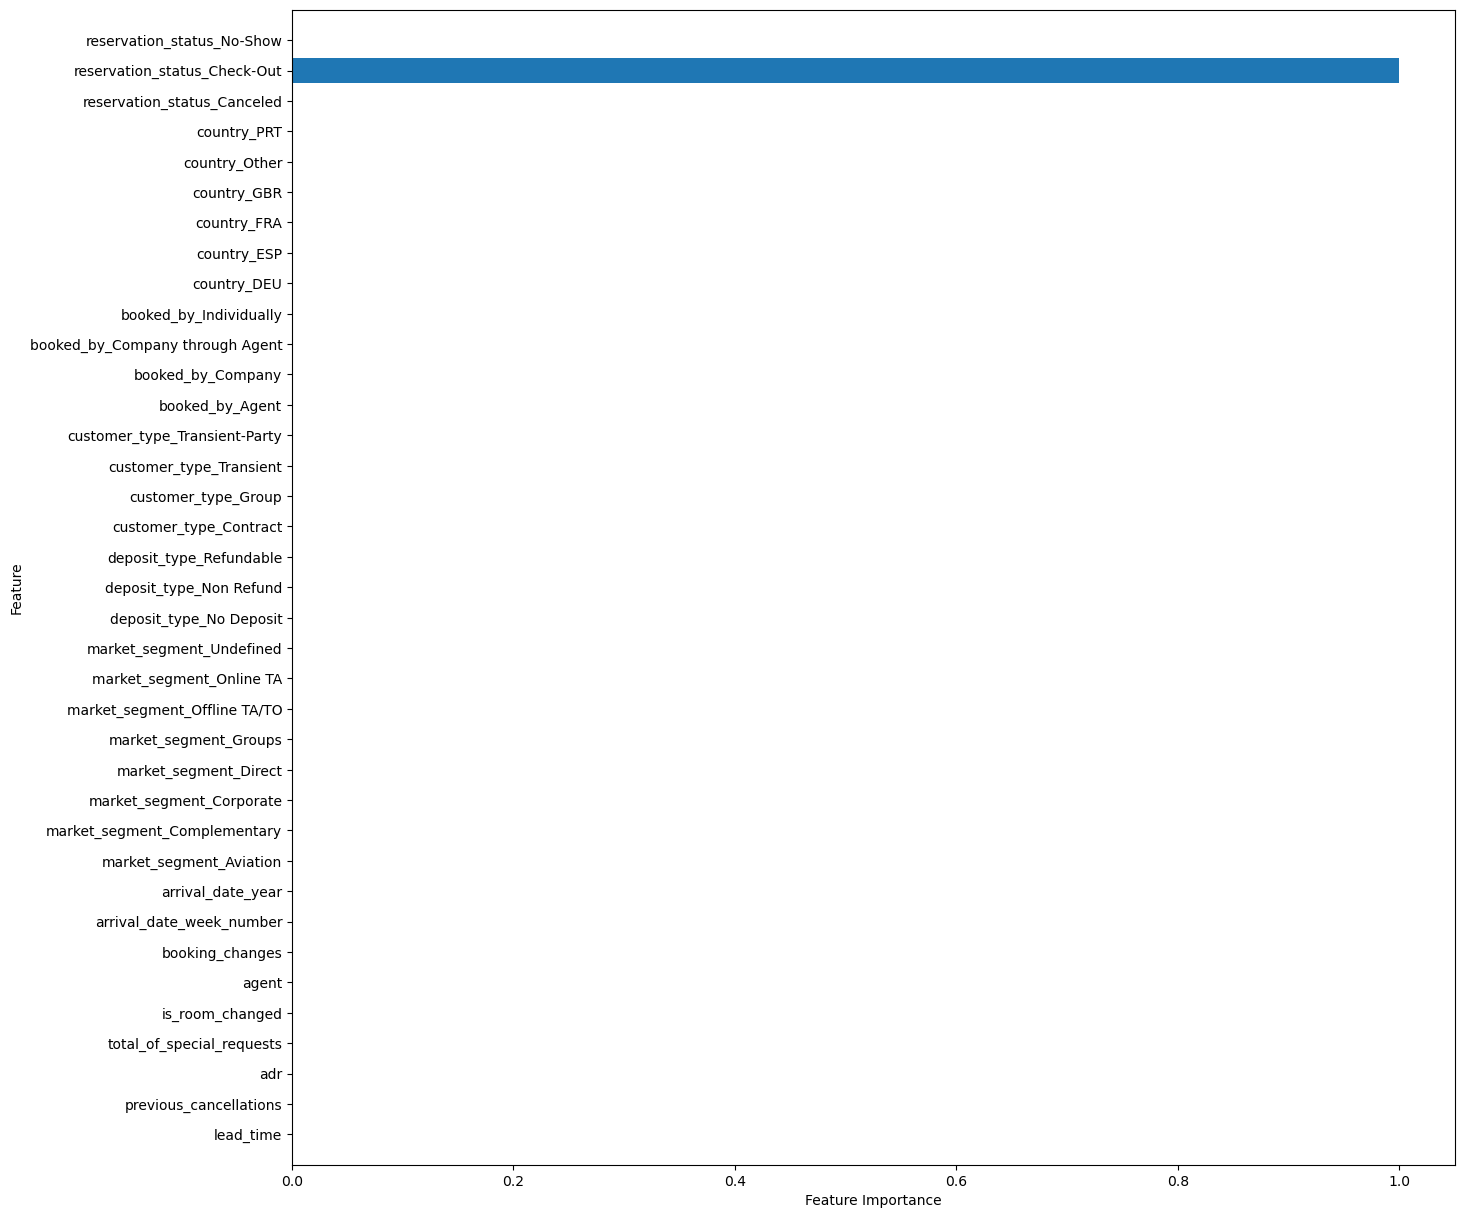

In [178]:
plot_feature_importances(X_train,gridSearch.best_estimator_)

Here I am running Decision tree with Grid SearhCV, to predict the Booking is cancelled or not, along with different parameters perfoming hyper parameter tunning.

Now, Decision Tree is running 12 models with a cross validation of 5 which means total 60 models are cross checked to consider the best parametrer.

Best Model states that **Max Depth should be 5** and **Minimum Sample should be 5**, to predict correctly.

Above is the best feature that is selected for the Decision Tree. 
From the Feature importance plot we can say that **reservation_status_Check-Out** is the best feature to predict whether the booking is canclled or not.

In [127]:
bestClassTree = gridSearch.best_estimator_
decision_tree_pred = bestClassTree.predict(X_test)
features_used = (gridSearch.best_estimator_.feature_importances_>0).sum()
decision_tree_dict = {"Model": "Decision Tree",
              "Accuracy": round(accuracy_score(y_test, decision_tree_pred),3),
              "Recall": round(recall_score(y_test, decision_tree_pred),3),
              "Precision": round(precision_score(y_test, decision_tree_pred),3),
              "False Negative": confusion_matrix(y_test, decision_tree_pred)[1][0],
              "False Positive": confusion_matrix(y_test, decision_tree_pred)[0][1],
              "Features Used": features_used,
              "Max Depth": best_model_results['param_max_depth'],
              "Minimum Impurity Decrease": best_model_results['param_min_impurity_decrease'],
              "Minimum Samples Split": best_model_results['param_min_samples_split'],
              "Time in seconds": total_time}

df_results = df_results.append(decision_tree_dict,ignore_index=True)

C:\Users\anagbhid\AppData\Local\Temp\ipykernel_2148\1510962713.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(decision_tree_dict,ignore_index=True)


In [128]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Time in seconds,Max Depth,Minimum Impurity Decrease,Minimum Samples Split
0,Logistic Regression,1.00,1.00,1.00,0,0,32,0.66,NaN,NaN,NaN
1,Decision Tree,1.00,1.00,1.00,0,0,1,1.31,5.00,0.00,5.00


# Random Forest

In [184]:
start_time = time.time()
random_forest_2 = RandomForestClassifier(random_state=1)
param_grid = { 
    'max_depth': [3,5,7],
    'min_samples_split': [5,7],
    'min_impurity_decrease': [0, 0.0001],
    'criterion' :['gini', 'entropy'],
}
random_forest_grid_search_2 = GridSearchCV(estimator=random_forest_2, param_grid=param_grid, cv= 5,scoring=['accuracy','recall','precision'],
                          refit='accuracy')
random_forest_grid_search_2.fit(X_train, y_train)

best_random_forest_2 = random_forest_grid_search_2.best_estimator_
random_forest_pred_2 = best_random_forest_2.predict(X_test)
total_time = time.time() - start_time
features_used = (best_random_forest_2.feature_importances_>0).sum()
random_forest_dict_2 = {"Model": "Random Forest",
              "Accuracy": round(accuracy_score(y_test, random_forest_pred_2),3),
              "Recall": round(recall_score(y_test, random_forest_pred_2),3),
              "Precision": round(precision_score(y_test, random_forest_pred_2),3),
              "False Negative": confusion_matrix(y_test, random_forest_pred_2)[1][0],
              "False Positive": confusion_matrix(y_test, random_forest_pred_2)[0][1],
              "Features Used": features_used,
              "Max Depth": best_random_forest_2.get_params().get('max_depth'),
              "Minimum Impurity Decrease": best_random_forest_2.get_params().get('min_impurity_decrease'),
              "Minimum Samples Split": best_random_forest_2.get_params().get('min_samples_split'), 
              "Time in seconds": total_time}


df_results = df_results.append(random_forest_dict_2,ignore_index=True)

C:\Users\anagbhid\AppData\Local\Temp\ipykernel_2148\2121228970.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(random_forest_dict_2,ignore_index=True)


In [186]:
# best_model_results
#best hypertuned parameters 
print("Max Depth : ", best_random_forest_2.max_depth)
print("Minimum Sample : ", best_random_forest_2.min_samples_split)
print("Impurity Decrease : ", best_random_forest_2.min_impurity_decrease)
print("Criteria for Chosing the splitting : ", random_forest_2.criterion)

Max Depth :  3
Minimum Sample :  5
Impurity Decrease :  0
Criteria for Chosing the splitting :  gini


Here we are, performing Random Forest to predict the bookings using hyper parameter tunning  to run 24 models with cross validation of 5, which means we are validating 120 models to consider the best results.

Here as we have to reduce the complexity of the model, I think the cost complexity for running the Random Forest would be very high compared to decision tree. 

So we need to consider between Decision Tree and Random forest which is perfomring better. 

From the above results we can see that best result for **Max Depth is 3**, **MInimum Sample is 5**, and criteria for choosing the splitting is **Gini**

In [131]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Time in seconds,Max Depth,Minimum Impurity Decrease,Minimum Samples Split
0,Logistic Regression,1.00,1.00,1.00,0,0,32,0.66,NaN,NaN,NaN
1,Decision Tree,1.00,1.00,1.00,0,0,1,1.31,5.00,0.00,5.00
2,Random Forest,1.00,1.00,1.00,0,0,33,160.98,3.00,0.00,5.00


# Neural Network

In [139]:
start_time = time.time()
nural_net = MLPClassifier(hidden_layer_sizes=[35, 20], alpha=0.001, solver='adam', activation='relu',random_state=1)
nural_net.fit(X_train_std, y_train)
nural_net_pred = nural_net.predict(X_test_std)
total_time = time.time() - start_time
neural_nets_dict = {"Model": "Neural Nets",
                                          "Accuracy": round(accuracy_score(y_test, nural_net_pred),3),
                                          "Recall": round(recall_score(y_test, nural_net_pred),3),
                                          "Precision": round(precision_score(y_test, nural_net_pred),3),
                                          "False Negative": confusion_matrix(y_test, nural_net_pred)[1][0],
                                          "False Positive": confusion_matrix(y_test, nural_net_pred)[0][1],
                                          "Hidden Layers": '35,20',
                                          "Activation Function": 'relu',
                                          "Alpha": '0.001',
                                          "Time in seconds": total_time}
df_results = df_results.append(neural_nets_dict,ignore_index=True)


C:\Users\anagbhid\AppData\Local\Temp\ipykernel_2148\46616600.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(neural_nets_dict,ignore_index=True)


Neural Network is build using 2 hidden layers, Size = 25, 20, aAcgivation fucntion is **relu**.

In [140]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Time in seconds,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Activation Function,Alpha,Hidden Layers
0,Logistic Regression,1.00,1.00,1.00,0,0,32,0.66,NaN,NaN,NaN,NaN,NaN,NaN
1,Decision Tree,1.00,1.00,1.00,0,0,1,1.31,5.00,0.00,5.00,NaN,NaN,NaN
2,Random Forest,1.00,1.00,1.00,0,0,33,160.98,3.00,0.00,5.00,NaN,NaN,NaN
3,Neural Nets,1.00,1.00,1.00,1,0,NaN,4.74,NaN,NaN,NaN,relu,0.001,"35,20"


# Comparison of all the models

If we look at the above table we can see that all the models are perfoming Good with an **Accuracy** of 1. But our goal is to have zero False Negatives. So we cannot consider Neural Networks as we are getting 1 False Negative. 

Now we are left with three models, Logistic regression, Decsion Tree and Random Forest. We need to ceck whih model takes least time to process.

Processing Time -
 > Decisoin Tree  - **1.31 Sec**
 > Random forest - **160.98**
 > Logistic Regression - **0.66**
 
From above it seems that Logistic Regression seems to be best.

But if we consider the GridSearch Cross Validation for Decision Tree, we can see in 1.31 seconds 12 models and 60 cross validations are taking place which is much higher compared to time taken to run one Logistic Regression model whih takes 0.66 secs. 

Both the models are giiving similar results but Logistic Regression has a dependency of  classification threshold but Decisoin Tree doesn't, both the models have their pros and cons. I think Decision Tree, is performing better. 

Comparing Decison Tree to Random Forest we can that both the Accuracy & Recall is **1** but we need to consider such a model for which the processing & computing power is less. Here we should select Decision tree as it is performing equally better with same scores and less computing complexity. Comapred to Dt the RF has much much higher computing time, though validating 12 extra models. 

**For me comparing all models, I can say Decision Tree is performing better**.






# Winning Method

If we see the **df_results** we can say that, Decision Tree is using only one feature **reservation_status_Check-Out**, to give an accuracy of 1 and Recall of 1. With a Run time of 1.31 secs and using only 1 feature Decision Tree is the winning Method.

# Recommendation 

>- Employer can use this model to predict the booking cancellations, but we have a dominating feature (**reservation_status_Check-Out**) which is giving us the best accuracy and recall. 
>- We can ask employer more information which can be converted into new features and helps us in better prediction. 
>- If we drop the above mention feature most of the features available dont have correlation with booking cancelation. Model might generate considerable false negatives which will result in rooms being empty. This problem will be solved if hotel has high walk in customers 
>- Employer can provide information about walk in guest booking. If number of walk in customers is considerable then employer can choose model which is performing better in accuracy but not that good for recall as walk in guests will can always fill the rooms that get empty last minute
>- Employer can collect feedback from guests who cancel the booking to understand the reason. From those reasons employer migh get more insights regarding what type of data might be useful in the prediction
>- Employer can stop collecting the data which is not required to reduce the cost 